In [1]:
from os.path import join, exists
from glob import glob

import numpy as np
import pandas as pd

import json

from PIL import Image, ImageFilter

from sklearn import preprocessing
import matplotlib.pyplot as plt
from nilearn import image, plotting, masking

In [2]:
# from core.env import mlagent

In [3]:
import torch

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = 'cpu'

In [4]:
scaler = preprocessing.StandardScaler()

In [5]:
dir_root = '/mnt/ext5/DRN'
dir_behav = join(dir_root, 'behav_data')
dir_fmri = join(dir_root,'fmri_data')
dir_mask = join(dir_fmri, 'masks')
dir_model = join(dir_root,'model')

---

In [6]:
def state_processing(obs):
    vis_obs = []

    for _obs in obs:
        ## _obs.shape = (1, 72, 128, 3)
        vis_obs.append(_obs)

    ## visual observation [(1, 72, 128, 3) x 4]
    vis_obs = np.concatenate(vis_obs, axis=-1)
    ## visual observation (1, 72, 128, 12)
    vis_obs = np.transpose(vis_obs, (0, 3, 1, 2))
    vis_obs = (vis_obs * 255).astype(np.uint8)
    
    ## visual observation (1, 12, 72, 128)
    return vis_obs

In [7]:
def convert_time_to_sec(Time):
    m, s, ds = np.array(Time.split('-')).astype(int)
    return m*60+s+0.001*ds

---

In [9]:
subj = 'DRN04'

### fMRI data

In [5]:
Y = masking.apply_mask(
    imgs = join(dir_fmri,'preproc_data/%s/errts.%s.volreg.tproject.nii'%(subj,subj))
    , mask_img= join(dir_mask,'mask.group.n3.frac=0.7.nii')
)
Y = scaler.fit_transform(Y)
ntimepoints, nvoxels = Y.shape
print(ntimepoints, nvoxels)

8400 113158


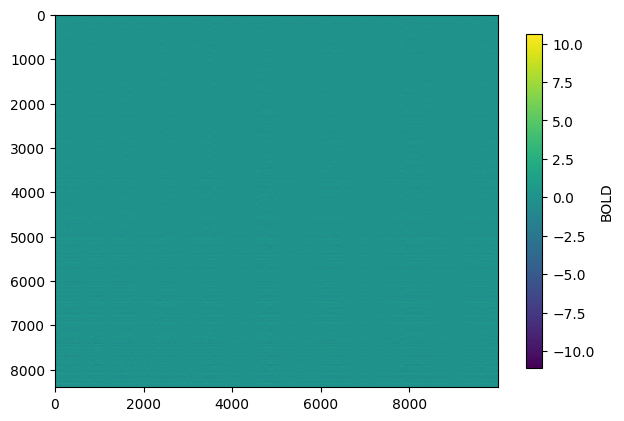

In [25]:
fig, ax = plt.subplots()
g = plt.imshow(Y[:,:10000])
fig.colorbar(g, shrink=0.75, label='BOLD')
fig.tight_layout()

### behavioral data

1. screen captures

In [10]:
from torchvision import transforms

convert_tensor = transforms.ToTensor()

In [11]:
resolution = (128,72)

In [12]:
dir_behav = '/mnt/ext5/DRN/behav_data/%s'%subj
dir_resize = join(dir_behav,'resized_%dx%d'%(resolution[0],resolution[1]))

In [13]:
list_fname = sorted(glob(join(dir_resize,'Run1/*.png')))

(72, 128, 3)

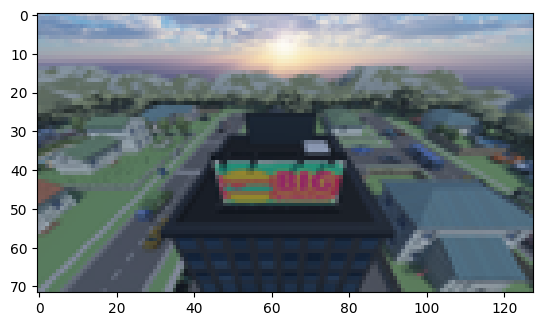

In [14]:
img = Image.open(list_fname[0])
plt.imshow(img)
np.asarray(img).shape

2. actions

In [15]:
run = 'Run1'

In [16]:
with open(join(dir_behav,run,'log.json'),'r') as f:
    behav = json.load(f)

---

the config

In [17]:
with open(join(dir_model,'drone_hanyang_mlagent.ppo/drone_hanyang_mlagent.json'),'r') as f:
    hanyang = json.load(f)
hanyang

{'env': {'name': 'drone_hanyang_mlagent', 'render': 'True', 'time_scale': 3.0},
 'agent': {'name': 'ppo',
  'network': 'continuous_policy_value',
  'head': 'cnn',
  'gamma': 0.95,
  'batch_size': 32,
  'n_step': 128,
  'n_epoch': 3,
  '_lambda': 0.95,
  'epsilon_clip': 0.1,
  'vf_coef': 1.0,
  'ent_coef': 0.01,
  'clip_grad_norm': 1.0,
  'use_standardization': 'True',
  'lr_decay': 'False'},
 'optim': {'name': 'adam', 'lr': 0.00025},
 'train': {'training': 'True',
  'load_path': './logs/drone_hanyang_mlagent/ppo/20230311094756544355/',
  'run_step': 30000000,
  'print_period': 10000,
  'save_period': 500000,
  'eval_iteration': 3,
  'record': 'False',
  'record_period': 1000000,
  'distributed_batch_size': 256,
  'update_period': "agent['n_step']",
  'num_workers': 5}}

## load pretrained parameters

In [18]:
ckpt = torch.load(
    join(dir_model,'drone_hanyang_mlagent.ppo/level2.ckpt')
    , map_location=device
)

In [19]:
for key1, dict_ in ckpt.items():
    print('################')
    print(key1)
    print('################')
    for key2, value in dict_.items():
        if type(value) is not dict:
            print('%s\n%s\n'%(key2,value.shape))
        else:
            break

################
network
################
head.conv1.weight
torch.Size([32, 12, 8, 8])

head.conv1.bias
torch.Size([32])

head.conv2.weight
torch.Size([64, 32, 4, 4])

head.conv2.bias
torch.Size([64])

head.conv3.weight
torch.Size([64, 64, 3, 3])

head.conv3.bias
torch.Size([64])

l.weight
torch.Size([512, 3840])

l.bias
torch.Size([512])

mu.weight
torch.Size([3, 512])

mu.bias
torch.Size([3])

log_std.weight
torch.Size([3, 512])

log_std.bias
torch.Size([3])

v.weight
torch.Size([1, 512])

v.bias
torch.Size([1])

################
optimizer
################


---

# Encoding model

### PCA

---

#### Network

In [20]:
from core.network import *

InputShape = (12,72,128)
network = policy_value.ContinuousPolicyValue(D_in=InputShape, D_out=3, D_hidden=512, head='cnn')
network.eval().to(device)

ContinuousPolicyValue(
  (head): CNN(
    (conv1): Conv2d(12, 32, kernel_size=(8, 8), stride=(4, 4))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (l): Linear(in_features=3840, out_features=512, bias=True)
  (mu): Linear(in_features=512, out_features=3, bias=True)
  (log_std): Linear(in_features=512, out_features=3, bias=True)
  (v): Linear(in_features=512, out_features=1, bias=True)
)

In [21]:
(mu, std, v), (conv1, conv2, conv3) = network(torch.rand(InputShape).to(device))

conv1.shape, conv2.shape, conv3.shape, mu.shape, std.shape, v.shape

(torch.Size([32, 17, 31]),
 torch.Size([64, 7, 14]),
 torch.Size([64, 5, 12]),
 torch.Size([3]),
 torch.Size([3]),
 torch.Size([1]))

#### copy parameters `network.head.weight = torch.nn.Parameter(ckpt['network'].head)`

In [22]:
network.load_state_dict(ckpt['network'])

<All keys matched successfully>

#### Input

In [23]:
nFrameStack = 4
list_ = list_fname[10:100]

## 4의 배수 frame 수로 자름
nInput = len(list_)//nFrameStack
list_ = np.array(list_[0:nInput*nFrameStack]).reshape(-1,4)

In [24]:
## outputs
conv1_stack = torch.zeros(nInput, *conv1.shape)
conv2_stack = torch.zeros(nInput, *conv2.shape)
conv3_stack = torch.zeros(nInput, *conv3.shape)
mu_stack = torch.zeros(nInput, *mu.shape)
std_stack = torch.zeros(nInput, *std.shape)
v_stack = torch.zeros(nInput, *v.shape)

In [25]:
for ii, frames in enumerate(list_):
#     input_ = torch.cat([convert_tensor(Image.open(f)) for f in frames], dim=0)
    input_ = np.stack([np.asarray(Image.open(f)).reshape((1,72,128,3)) for f in frames], axis=0)
    input_preproc = state_processing(input_)
    input_preproc = torch.from_numpy(input_preproc)
    ## 쌓은 frame 들을 network에 입력
    with torch.no_grad():
        output_ = network(input_preproc.to(device))
    (mu_stack[ii], std_stack[ii], v_stack[ii]), (conv1_stack[ii], conv2_stack[ii], conv3_stack[ii]) = output_

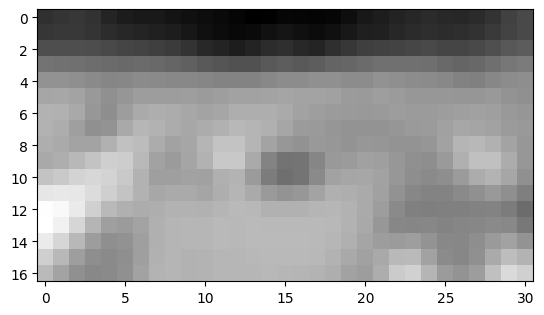

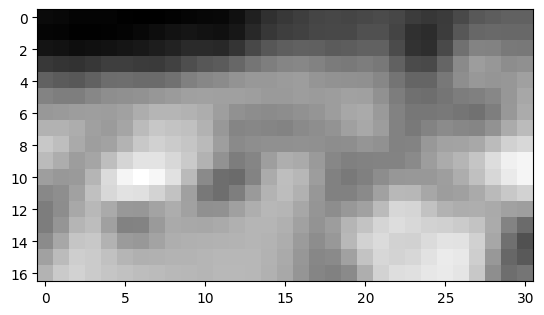

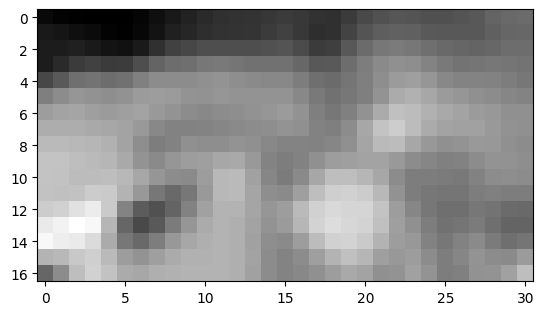

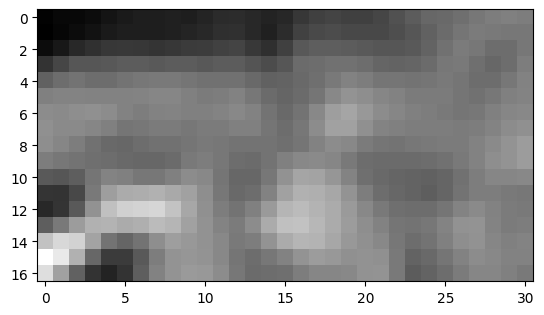

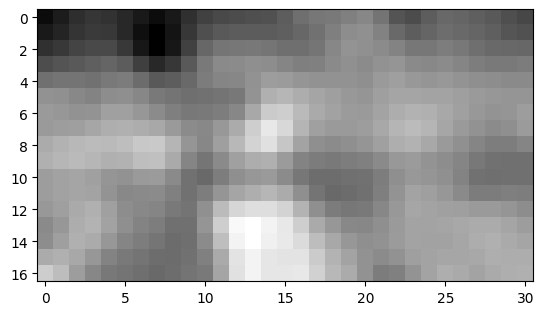

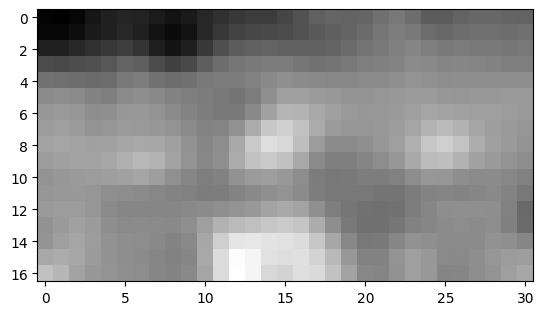

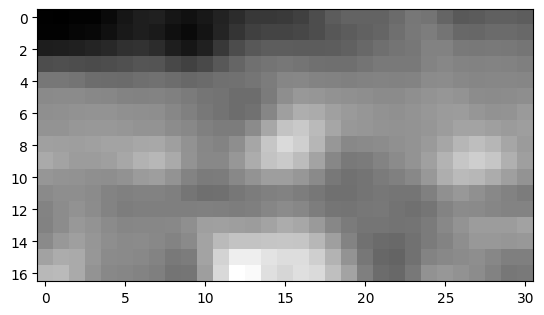

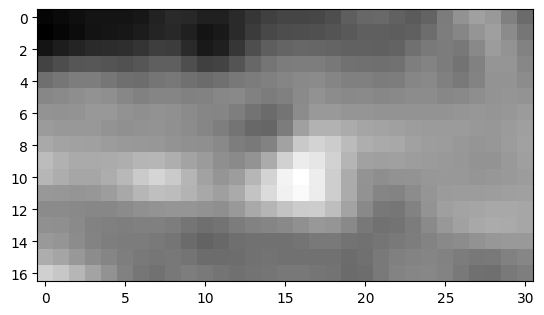

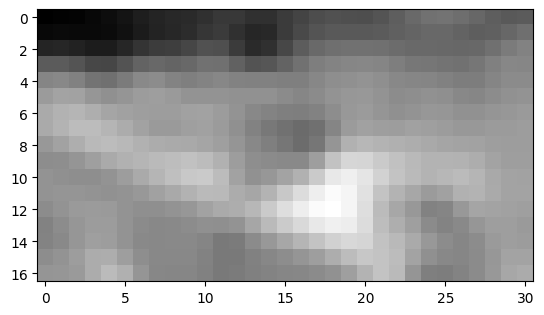

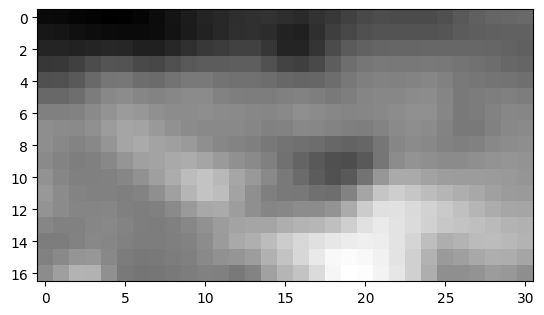

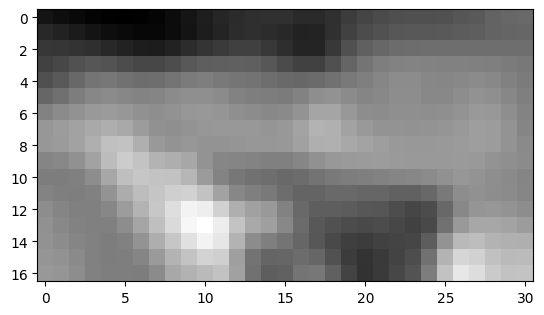

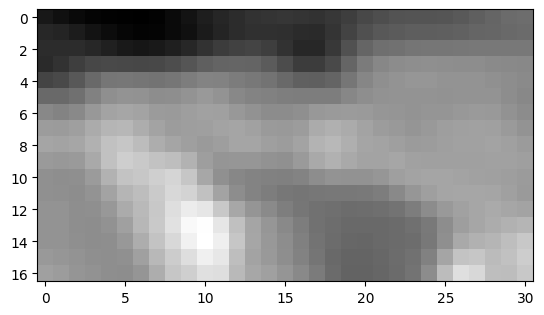

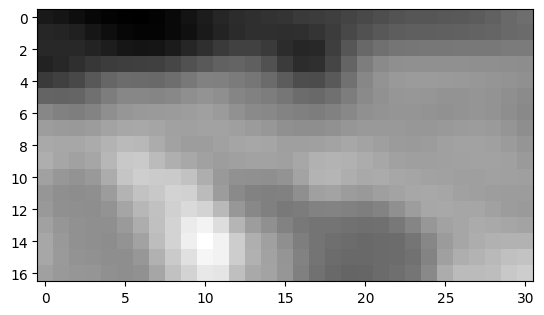

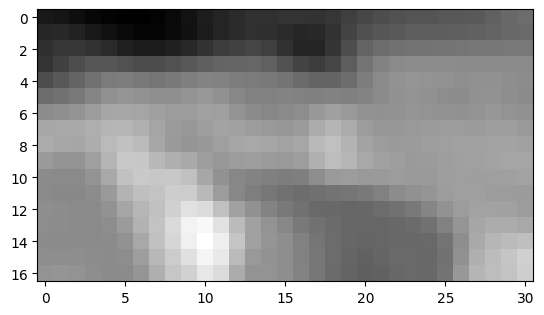

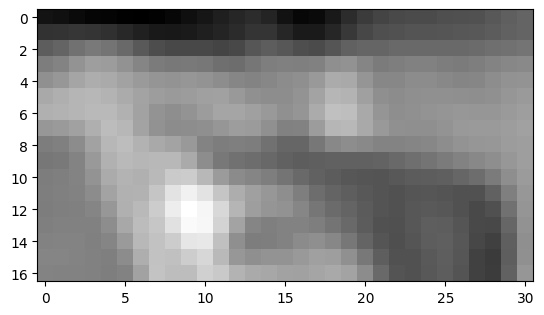

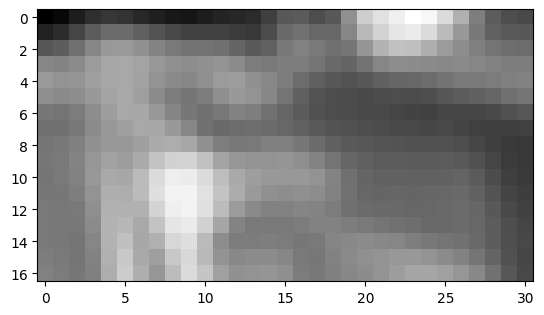

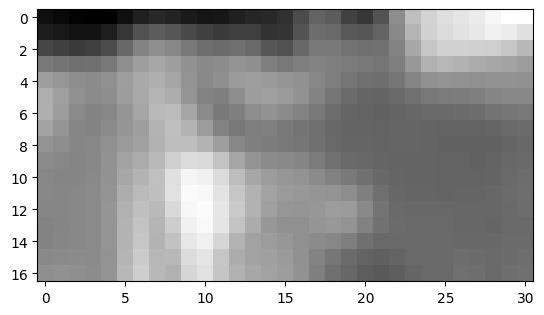

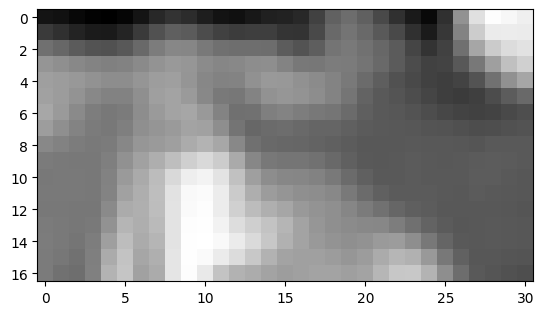

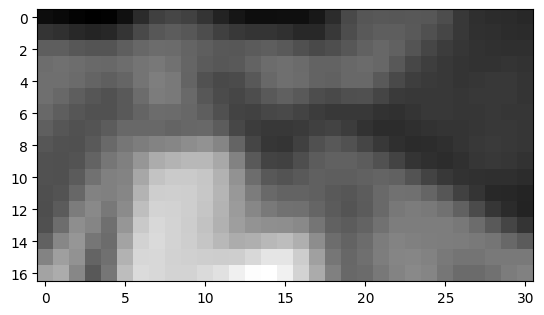

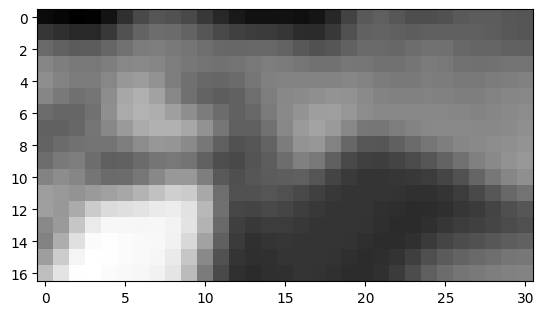

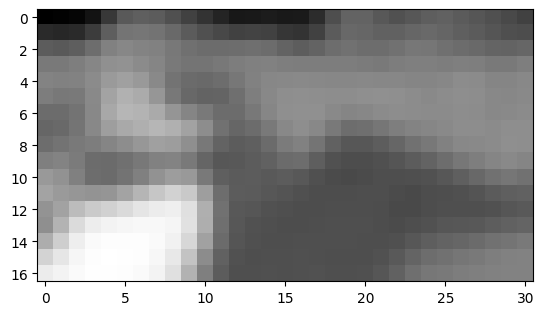

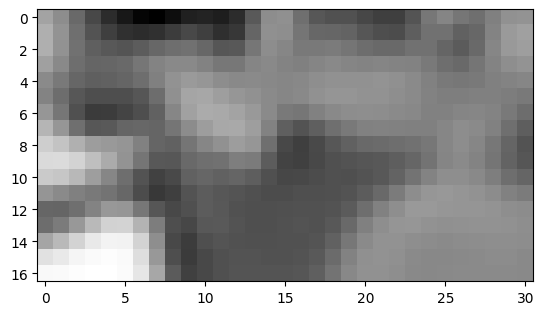

In [26]:
for conv1 in conv1_stack:
    tmp = torch.sum(conv1, dim=0).to('cpu').numpy()
    min_ = tmp.min(axis=(0,1))
    max_ = tmp.max(axis=(0,1))
    tmp = (tmp-min_)*255/(max_-min_)
    img = Image.fromarray(tmp.astype(np.uint8), mode='L')
    img = img.filter(ImageFilter.GaussianBlur(radius=1))
    plt.imshow(img, cmap='gray')
    plt.show()

In [27]:
print(mu_stack)
print(std_stack)
print(v_stack)

tensor([[-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-4.9757,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  2.4783,  3.2116],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000],
        [-5.0000,  5.0000,  5.0000]])
tensor([[2.6964, 2.7183, 2.7183],
        [2.7164, 2.7183, 2.7183],
        [2.7175, 2.7183, 2.7183],
        [2.7140, 2.7183, 2.7183],
        [0.7838, 2.7183, 2.7183],
        [1.0438

---

---

pycortex

set up the environment variables for the pycortex

In [ ]:
import sklearn
sklearn.set_config(assume_finite=True)

---

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA

---

In [1]:
from himalaya.backend import set_backend

In [3]:
backend = set_backend('cupy')

---

# Compute the explainable variance

Before fitting any voxelwise model to fMRI responses, it is good practice to
quantify the amount of signal in the test set that can be predicted by an
encoding model. This quantity is called the *explainable variance*.

The measured signal can be decomposed into a sum of two components: the
stimulus-dependent signal and noise. If we present the same stimulus multiple
times and we record brain activity for each repetition, the stimulus-dependent
signal will be the same across repetitions while the noise will vary across
repetitions. In voxelwise modeling, the features used to model brain activity
are the same for each repetition of the stimulus. Thus, encoding models will
predict only the repeatable stimulus-dependent signal.

The stimulus-dependent signal can be estimated by taking the mean of brain
responses over repeats of the same stimulus or experiment. The variance of the
estimated stimulus-dependent signal, which we call the explainable variance, is
proportional to the maximum prediction accuracy that can be obtained by a
voxelwise encoding model in the test set.

Mathematically, let $y_i, i = 1 \dots N$ be the measured signal in a
voxel for each of the $N$ repetitions of the same stimulus and
$\bar{y} = \frac{1}{N}\sum_{i=1}^Ny_i$ the average brain response
across repetitions. For each repeat, we define the residual timeseries between
brain response and average brain response as $r_i = y_i - \bar{y}$. The
explainable variance (EV) is estimated as

\begin{align}\text{EV} = \frac{1}{N}\sum_{i=1}^N\text{Var}(y_i) - \frac{N}{N-1}\sum_{i=1}^N\text{Var}(r_i)\end{align}


In the literature, the explainable variance is also known as the *signal
power*.

In [ ]:
ncondition

Then, we compute the explainable variance for each voxel.

In [14]:
from voxelwise_tutorials.utils import explainable_variance

ev = explainable_variance(Y)
print("(n_voxels,) =", ev.shape)

(n_voxels,) = (113158,)


To better understand the concept of explainable variance, we can plot the
measured signal in a voxel with high explainable variance...

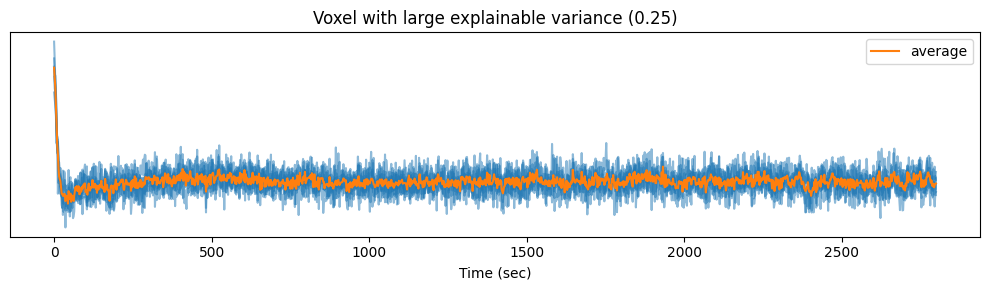

In [16]:
voxel_1 = np.argmax(ev)
time = np.arange(Y.shape[1]) * 2  # one time point every 2 seconds
plt.figure(figsize=(10, 3))
plt.plot(time, Y[:, :, voxel_1].T, color='C0', alpha=0.5)
plt.plot(time, Y[:, :, voxel_1].mean(0), color='C1', label='average')
plt.xlabel("Time (sec)")
plt.title("Voxel with large explainable variance (%.2f)" % ev[voxel_1])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

... and in a voxel with low explainable variance.

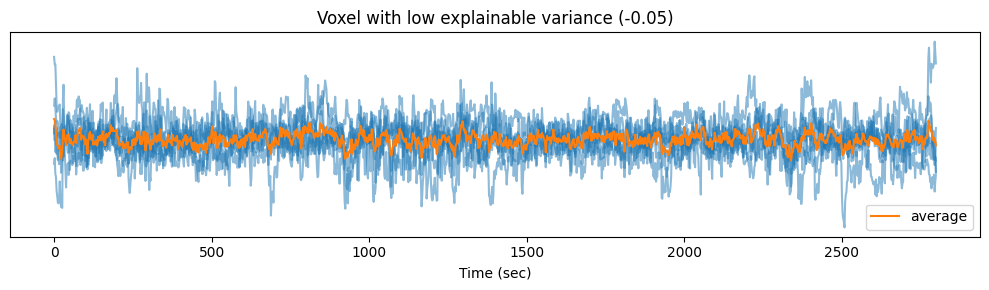

In [17]:
voxel_2 = np.argmin(ev)
plt.figure(figsize=(10, 3))
plt.plot(time, Y[:, :, voxel_2].T, color='C0', alpha=0.5)
plt.plot(time, Y[:, :, voxel_2].mean(0), color='C1', label='average')
plt.xlabel("Time (sec)")
plt.title("Voxel with low explainable variance (%.2f)" % ev[voxel_2])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

We can also plot the distribution of explainable variance over voxels.

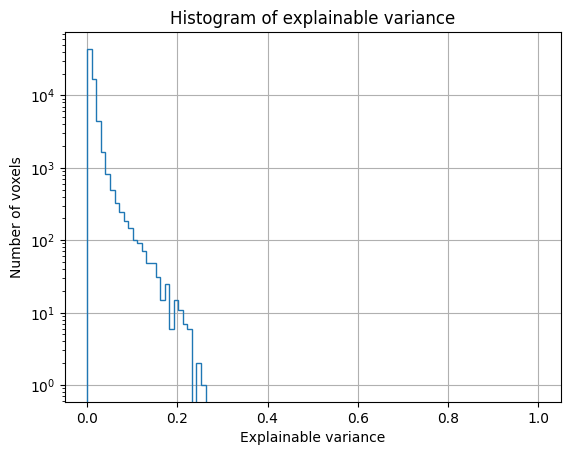

In [18]:
plt.hist(ev, bins=np.linspace(0, 1, 100), log=True, histtype='step')
plt.xlabel("Explainable variance")
plt.ylabel("Number of voxels")
plt.title('Histogram of explainable variance')
plt.grid('on')
plt.show()

---